In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('dark')
plt.rcParams['font.family'] = 'Palatino Linotype'

In [2]:
# 异常数据所在的范围
TRAIN_LEFT = 400000
TRAIN_RIGHT = 440000
L_1 = 66951
R_1 = 82701

# Pytorch DenseAutoEncoder

## 设置随机种子

In [3]:
import torch
import torch.nn as nn 

In [4]:
np.random.seed(1)
torch.manual_seed(2)
SEED = 123

## 创建全连接AE的dataset

In [5]:
# 数据加载的基类
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x):
        super(Dataset,self).__init__()
        self.dataset = x
    def __len__(self):
        # 重载
        return len(self.dataset)
    def __getitem__(self,idx):
        # 重载
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'flag'}) # 丢掉flag列
        tensor = torch.from_numpy(np.array(row)).float() # 将array转换为tensor
        return tensor

## 搭建全连接AutoEncoder

In [6]:
# 自编码器
class AutoEncoder(nn.Module):
    def __init__(self,input_dim):
        super(AutoEncoder,self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            # nn.Linear(input_dim,128),
            # nn.ReLU(),
            # nn.Linear(128,64),
            # nn.ReLU(),
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU()
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,input_dim),
            nn.ReLU(),
            # nn.Linear(128,256),
            # nn.ReLU(),
            # nn.Linear(256,512),
            # nn.ReLU(),
            # nn.Linear(512,input_dim),
            # nn.ReLU()
        )

    def forward(self,x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)

        return decoder

## 全连接AutoEncoder数据标准化

In [7]:
data = pd.read_csv('data_4334.csv',index_col=0)

In [8]:
data.head(n=3)

,max_bat_mer_v,min_bat_mer_v,max_temp,min_temp,total_voltage,total_current,soc,mbv0,mbv1,mbv2,...,etpd39,etpd40,etpd41,etpd42,etpd43,etpd44,etpd45,etpd46,etpd47,flag
0,3.666,3.648,32,30,351.5,13.0,53,3.658,3.658,3.665,...,31.0,32.0,32.0,32.0,32.0,31.0,31.0,32.0,31.0,0
1,3.674,3.661,32,30,352.4,29.0,53,3.670,3.666,3.672,...,31.0,32.0,32.0,32.0,32.0,31.0,31.0,32.0,31.0,0
2,3.672,3.659,32,30,352.1,-5.0,52,3.664,3.664,3.670,...,31.0,32.0,32.0,32.0,32.0,31.0,31.0,32.0,31.0,0


## 数据集分割

In [9]:
train_data = data.loc[TRAIN_LEFT:TRAIN_RIGHT].drop('flag',axis=1)
train_flag = data.loc[TRAIN_LEFT:TRAIN_RIGHT]['flag']

valid_data = pd.concat(
    [
        data.loc[TRAIN_RIGHT:TRAIN_RIGHT+5000].drop('flag',axis=1),
        data.loc[L_1:R_1-10000].drop('flag',axis=1)
    ]
)
valid_flag = pd.concat(
    [
        data.loc[TRAIN_RIGHT:TRAIN_RIGHT+5000]['flag'],
        data.loc[L_1:R_1-10000]['flag']
    ]
)
test_data = pd.concat(
    [
        data.loc[TRAIN_RIGHT+5000:TRAIN_RIGHT+10000].drop('flag',axis=1),
        data.loc[R_1-10000:R_1].drop('flag',axis=1)
    ]
)
test_flag = pd.concat(
    [
        data.loc[TRAIN_RIGHT+5000:TRAIN_RIGHT+10000]['flag'],
        data.loc[R_1-10000:R_1]['flag']
    ]
)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_data)

train_data = scaler.transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)

train_data = pd.DataFrame(data=np.concatenate((train_data,train_flag.values.reshape(-1,1)),axis=1),index=train_flag.index,columns=data.columns)
valid_data = pd.DataFrame(data=np.concatenate((valid_data,valid_flag.values.reshape(-1,1)),axis=1),index=valid_flag.index,columns=data.columns)
test_data = pd.DataFrame(data=np.concatenate((test_data,test_flag.values.reshape(-1,1)),axis=1),index=test_flag.index,columns=data.columns)

In [11]:
train_data.head(n=3)

,max_bat_mer_v,min_bat_mer_v,max_temp,min_temp,total_voltage,total_current,soc,mbv0,mbv1,mbv2,...,etpd39,etpd40,etpd41,etpd42,etpd43,etpd44,etpd45,etpd46,etpd47,flag
400000,0.682205,0.707257,1.281351,1.081293,0.711737,1.484955,0.819706,0.700305,0.698057,0.702675,...,0.841433,0.947299,0.949483,1.140737,0.908001,1.232324,1.024458,1.154636,1.098509,0.0
400001,0.698430,0.610033,1.281351,1.081293,0.683587,1.232634,0.819706,0.646288,0.627728,0.627152,...,0.841433,0.947299,0.949483,1.140737,0.908001,1.232324,1.024458,1.154636,1.098509,0.0
400002,0.703838,0.707257,1.281351,1.081293,0.711737,-0.000938,0.819706,0.711108,0.703467,0.708069,...,0.841433,0.947299,0.949483,1.140737,0.908001,1.232324,1.024458,1.154636,1.098509,0.0


## 训练前准备工作 创建数据loader和赋值超参

In [12]:
# 超参数
BATCH_SIZE = 32 # 每批数据的量
LR = 1e-2 # 学习率
MOMENTUM = 0.9 
DECAY = 1e-5 # 权重衰减
EPOCHS = 30 # 训练回合数

In [13]:
from collections import defaultdict
# 使用gpu训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'

metrics = defaultdict(list)

# 加载数据
train_set = Dataset(x=train_data)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# 创建自编码器工作
# model = AutoEncoder(input_dim=train_data.shape[1]-1)
# model.to(device)

model = AutoEncoder(input_dim=train_data.shape[1]-1)
model.load_state_dict(torch.load('car_4334_fcae.pth'))
model.to(device)

# 损失函数 MSE
criterion = nn.MSELoss(reduction='mean')
# 优化器 SGD
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = LR,
    weight_decay = DECAY
)

## Training

In [14]:
# model.train() # 将model设置为训练状态
# for epoch in range(EPOCHS):
#     running_loss = 0.0
#     for _, data in enumerate(train_loader):
#         sample = model(data.to(device)) # 将数据送入模型
#         loss = criterion(data.to(device),sample) # 计算误差
#         # 反向传播
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     epoch_loss = running_loss / len(train_set)
#     if (epoch % 2 == 0):
#         print('Epoch:{} Train_Loss:{}'.format(epoch,epoch_loss))
#     metrics['train_loss'].append(epoch_loss)
# torch.save(model.state_dict(),'car_4334_fcae.pth') # 保存模型
# np.savetxt('car_4334_fcae_train_loss.txt',np.array(metrics['train_loss'])) # 保存模型训练loss

In [15]:
# fig = plt.figure(figsize=(30,15))

# plt.rc('font',size=20)
# plt.ticklabel_format(style='sci')
# plt.tick_params(labelsize=25)
# plt.plot(metrics['train_loss'],linewidth=3,label='train_loss')
# plt.legend(fontsize=25)

# plt.show()

## Validation集设置Threshold

In [16]:
from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import recall_score,classification_report,auc,roc_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [17]:
model.eval() # 将模型调至evaluation模式
for idx,row in valid_data.iterrows():
    data = row.drop(labels={'flag'})
    data = torch.from_numpy(np.array(data)).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device),sample)
    metrics['validation_loss'].append(loss.item())

np.savetxt('car_4334_fcae_validation_loss.txt',np.array(metrics['validation_loss'])) # 保存模型 validation loss
loss_df = pd.DataFrame({'rebuilt_loss':metrics['validation_loss'],'flag':valid_data['flag']})

In [21]:
idxs = list(loss_df[loss_df['rebuilt_loss']>100].index)
for idx in idxs:
    loss_df.loc[idx,'rebuilt_loss'] = loss_df.loc[idx-1,'rebuilt_loss']

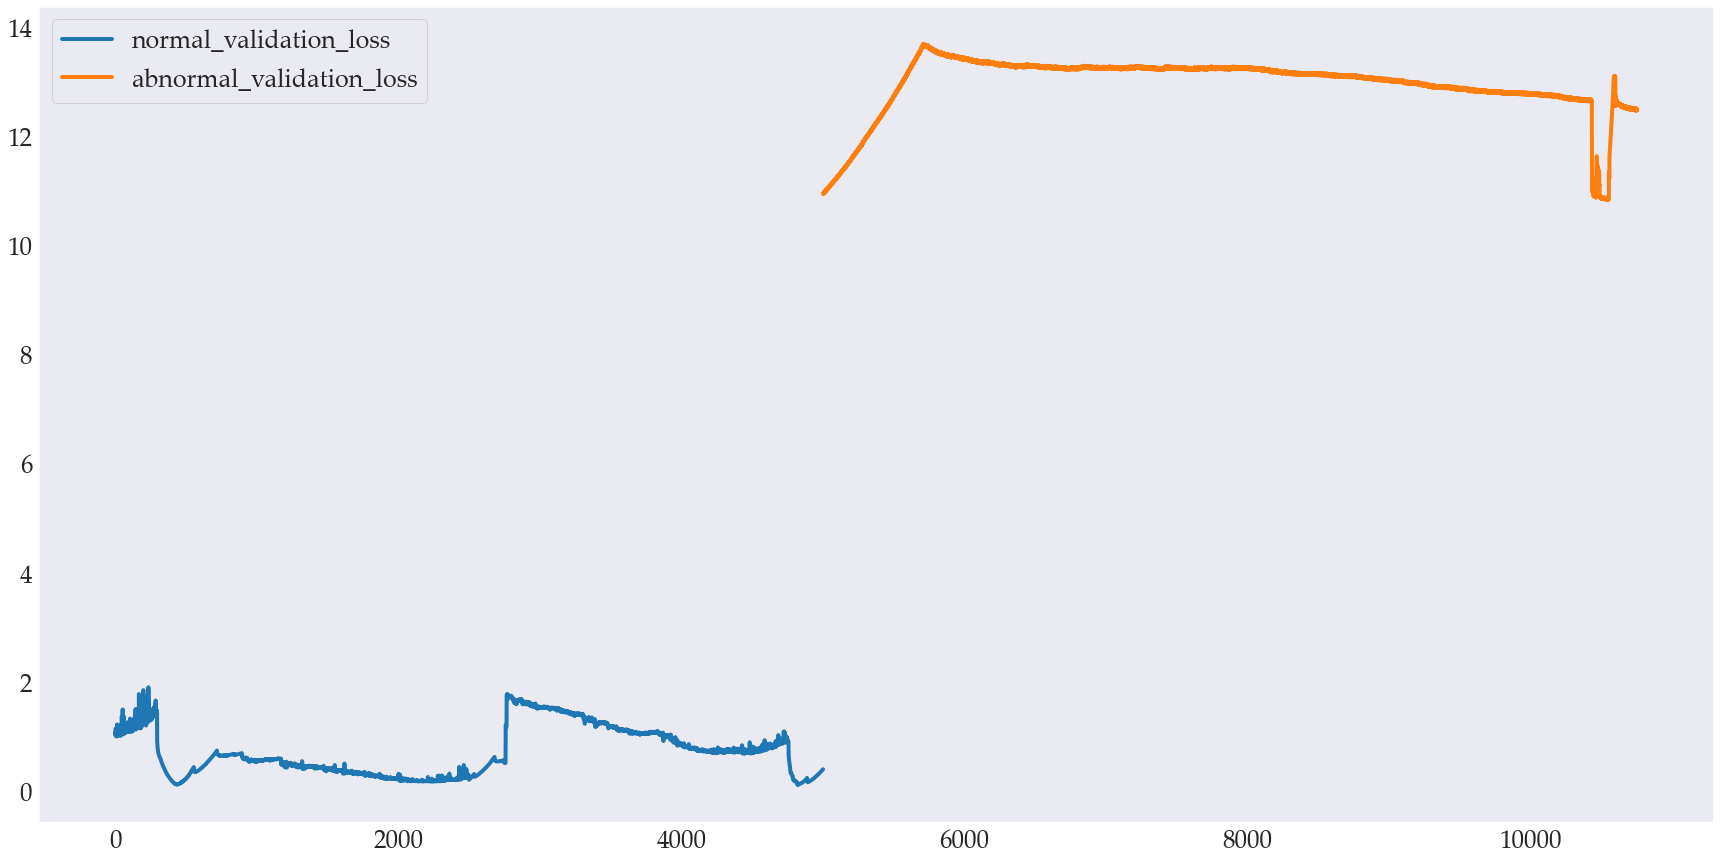

In [22]:
tmp_df = loss_df.reset_index()

fig = plt.figure(figsize=(30,15))
plt.rc('font',size=25)
plt.plot(tmp_df[tmp_df['flag']==0]['rebuilt_loss'],label='normal_validation_loss',linewidth=4)
plt.plot(tmp_df[tmp_df['flag']==1]['rebuilt_loss'],label='abnormal_validation_loss',linewidth=4)
plt.legend()
plt.show()

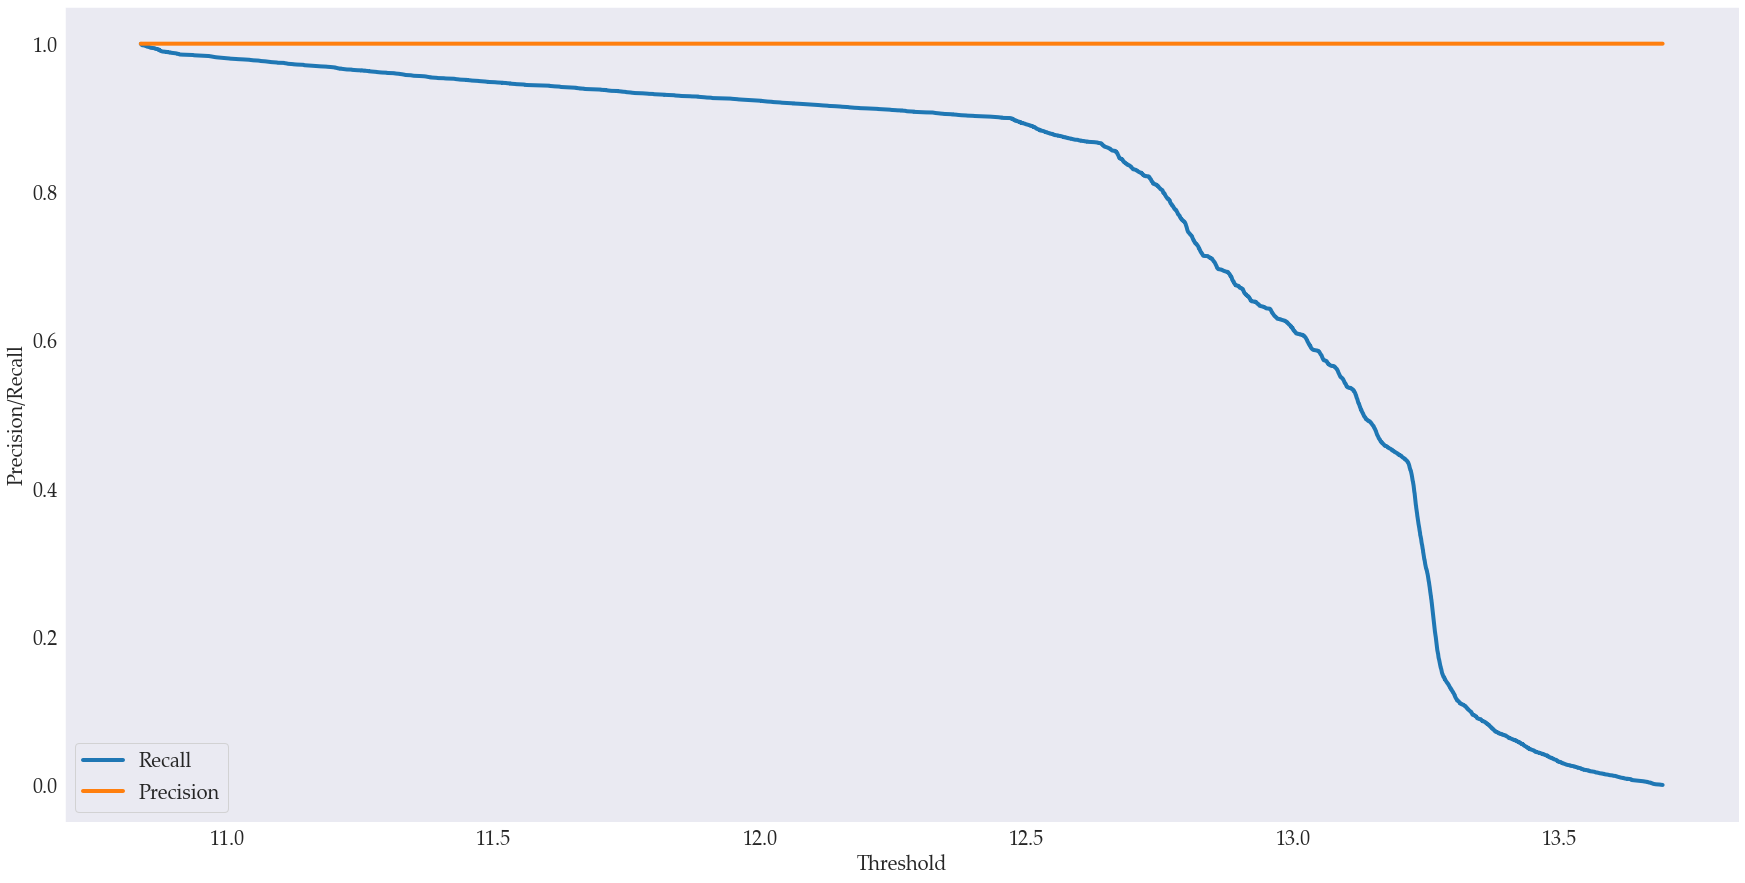

In [23]:
precision_rt,recall_rt,threshold_rt = precision_recall_curve(loss_df.flag,loss_df.rebuilt_loss)

fig = plt.figure(figsize=(30,15))
plt.rc('font',size=20)
plt.plot(threshold_rt,recall_rt[1:],label='Recall',linewidth=4)
plt.plot(threshold_rt,precision_rt[1:],label='Precision',linewidth=4)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

plt.show()

## 测试集测试模型的性能

In [24]:
metrics['test_loss'] = []
for idx,row in test_data.iterrows():
    data = row.drop(labels={'flag'})
    data = torch.from_numpy(np.array(data)).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device),sample)
    metrics['test_loss'].append(loss.item())

np.savetxt('car_4334_fcae_test_loss.txt',np.array(metrics['test_loss'])) # 保存模型训练loss

In [26]:
THRESHOLD = 11

test_loss_df = pd.DataFrame({'rebuilt_loss':metrics['test_loss'],'flag':test_data['flag']})
idxs = list(test_loss_df[test_loss_df['rebuilt_loss']>100].index)
for idx in idxs:
    test_loss_df.loc[idx,'rebuilt_loss'] = test_loss_df.loc[idx-1,'rebuilt_loss']

<Figure size 2160x1080 with 0 Axes>

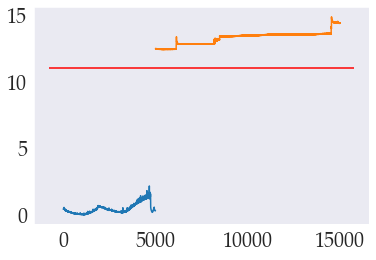

In [27]:
tmp_df = test_loss_df.reset_index()
groups = tmp_df.groupby('flag')

plt.figure(figsize=(30,15))
fig,ax = plt.subplots()
plt.rc('font',size=20)
for name,group in groups:
    ax.plot(group.index,group.rebuilt_loss,label='Abnormal' if name==1 else 'Normal')
ax.hlines(THRESHOLD,ax.get_xlim()[0],ax.get_xlim()[1],colors='r',label='Threshold')

plt.show()